# Projet de synthèse: PMM

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from collections import Counter
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import warnings
warnings.filterwarnings('ignore')
# !pip install imblearn
# !pip install category_encoders


#### Fonctions qui seront utilisées

In [2]:
def drop_columns(df, features):
    for feature in features:
        df.drop(feature, axis=1, inplace=True)
    
    
def bar_plot(variable):
    plt.figure(figsize=(18,8))
    plt.xticks(rotation=100)
    df[variable].value_counts(normalize=True).plot(kind='bar')    
    plt.ylabel('Proportion')
    plt.title('Distribution de '+ str(variable))
    return plt.show()

def histo_plot(variable):
    plt.figure(figsize=(18,8))
    sns.distplot(df[variable], kde=False)
    plt.title('Histogramme de '+str(variable))
    return plt.show()

def box_plot(variable):
    sns.boxplot(y=df[variable])
    plt.title('Boxplot de '+str(variable))
    return plt.show()

def variables_cat(df, val_cat = [] ):
    for i in df.columns:
        if df[i].dtype == 'object':
            val_cat.append(i)
            
def variables_num(df, val_num = [] ):
    for i in df.columns:
        if df[i].dtype == 'int64' or df[i].dtype == 'float64':
            val_num.append(i)

def replacement(df, val_old, val_new):
    return df.replace(val_old, val_new)

def matr_correlation(df):
    fig = plt.figure(figsize=(15,15))
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    sns.heatmap(df.corr(), mask=mask, center=0, cmap='RdBu', linewidths=1, annot=True, fmt='.1f', vmin=-1, vmax=1)
    plt.title('Matrice de correlation des variables', fontsize=15, fontweight='bold')
    plt.show()

val_skew = []

def assymetry(vals):
    for i in vals:
        val_skew.append(df[i].skew())
        
    return pd.DataFrame(val_skew, columns=vals)

def impute_outliers(df, feature):
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr    
    df.loc[df[feature] < lower_bound, feature] = lower_bound
    df.loc[df[feature] > upper_bound, feature] = upper_bound
    
def boxPlot(df, val_x, val_y, title_x, title_y, title):
    plt.figure(figsize=(15,8))
    sns.boxplot(x=val_x, y =val_y, data=df)
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.show()
    
def show_mv(df):
    df_nan= pd.DataFrame(round(((df.isna().sum()/df.shape[0])*100),1).to_dict().items(), columns=['Champs', 'Val NaN %'])
    return df_nan[df_nan['Val NaN %']>0]

def show_columns30(df):
    df_nan= pd.DataFrame(round(((df.isna().sum()/df.shape[0])*100),1).to_dict().items(), columns=['Champs', 'Val NaN %'])
    return df_nan[(df_nan['Val NaN %']>0) & (df_nan['Val NaN %']<30)]

def replace_mv(feature, df):
    df[feature].fillna(df[feature].value_counts().index[0], inplace=True)

def replace_virgule(df, features):
       for i in features:
            df[i]=df[i].str.replace(',', '.')

def replace_virgule2(df, features):
       for i in features:
            df[i]=df[i].str.replace(',', '')
            
def replace_pourcentage(df, features):
       for i in features:
            df[i]=df[i].str.replace('%', '')

def conv_float(df, features):
    for i in features:       
        df[i] = df[i].astype('float')

def conv_int(df, features):
    for i in features:       
        df[i] = df[i].astype(int)

def conv_longint(df, features):
    for i in features:       
        df[i] = pd.to_numeric(df[i])
        
def replace_chaine(df, feature, val_old, val_new):
    df[feature]=df[feature].replace(val_old, val_new)    

### Importation des données

In [3]:
data = pd.read_excel('ml-datas/datasetfinal_rejetgr.xlsx')
df = data.copy()
df

,NomSemis,DateImplantation,DateRecolteVisee,AnneeProduction,Certification,NoEspece,NomEspece,NoProducteur,NoCultivar,NomCultivar,...,FinRecolte,DebutRecolte,Rejet_AutresDefauts,RejetDeclassement,Rejet_Dimensions,Rejet_Matiere_Etrangere,FertilizerAmount,IrrigationArea,IrrigationDuration,PesticideAmount
0,18-Bayonne-BR-44,2018-06-13,2018-08-17,2018,CONV,1,Brocoli,183,32,Monaco T,...,2018-09-04,2018-08-20,1.34,0.00,0.17,0.26,5703.55,0.0,0.0,37.9502
1,18-Bayonne-BR-45,2018-06-14,2018-08-18,2018,CONV,1,Brocoli,183,9,Batory T,...,2018-09-14,2018-08-23,0.47,0.00,0.23,0.16,4786.53,0.0,0.0,35.8789
2,18-Bayonne-BR-46,2018-06-17,2018-08-20,2018,CONV,1,Brocoli,183,32,Monaco T,...,2018-09-14,2018-08-25,1.19,0.00,0.07,0.28,3546.53,0.0,0.0,26.5759
3,18-Bayonne-BR-47,2018-06-18,2018-08-21,2018,CONV,1,Brocoli,183,9,Batory T,...,2018-09-18,2018-08-29,0.74,0.00,0.20,0.13,30742.66,0.0,0.0,38.0290
4,18-Bayonne-BR-48,2018-06-20,2018-08-23,2018,CONV,1,Brocoli,183,32,Monaco T,...,2018-09-18,2018-08-29,1.19,0.00,0.40,0.23,29503.03,0.0,0.0,36.4146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,22-Wolfe-BR-2,2022-06-22,2022-08-26,2022,CONV,1,Brocoli,144,56,Monaco NT,...,NaT,NaT,NaN,NaN,NaN,NaN,5602.80,0.0,0.0,48.7857
688,22-Wolfe-CF-1,2022-06-20,2022-09-11,2022,CONV,2,Chou-fleur,144,13,Casper T,...,2022-10-28,2022-08-30,0.85,0.64,0.41,0.00,2734.20,0.0,0.0,17.6551
689,22-Wolfe-CF-2,2022-06-26,2022-09-20,2022,CONV,2,Chou-fleur,144,13,Casper T,...,2022-10-27,2022-10-04,0.18,0.66,0.69,0.01,5316.50,0.0,0.0,11.6095
690,22-Wolfe-CF-3,2022-07-02,2022-09-29,2022,CONV,2,Chou-fleur,144,13,Casper T,...,2022-10-27,2022-10-04,0.16,0.59,1.08,0.01,2907.80,0.0,0.0,4.8825


#### Exclusion des données de 2018

In [4]:
df = df[df['AnneeProduction']>2018]

In [5]:
df.shape

(567, 55)

#### Consultations des variables

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 567 entries, 125 to 691
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   NomSemis                      567 non-null    object        
 1   DateImplantation              567 non-null    datetime64[ns]
 2   DateRecolteVisee              567 non-null    datetime64[ns]
 3   AnneeProduction               567 non-null    int64         
 4   Certification                 567 non-null    object        
 5   NoEspece                      567 non-null    int64         
 6   NomEspece                     567 non-null    object        
 7   NoProducteur                  567 non-null    int64         
 8   NoCultivar                    567 non-null    object        
 9   NomCultivar                   567 non-null    object        
 10  QteSemencesMillegrains        567 non-null    float64       
 11  EntreRangPo                   

## Prétraitement

In [7]:
features = ['NoEspece', 'NoProducteur', 'NoCultivar', 'EntreRangPo', 'RangPo']
drop_columns(df, features)

In [8]:
val_old = ['0.0']
val_new = ['Aucune']
replace_chaine(df, 'NbPlantsVersGris', val_old, val_new)

In [9]:
val_old = ['Autre tâche']
val_new = ['AT- Autres taches']
replace_chaine(df, 'Maladie', val_old, val_new)

In [10]:
val_old = [1, 2,3, 4,5,8, 7, 6,9,60, 20, 10,13,15,40,12,33,14,35,17,18,0]
val_new = ['FAIBLE (1 plant)', 'MOYEN (2-5 plants)', 'MOYEN (2-5 plants)', 'MOYEN (2-5 plants)', 'MOYEN (2-5 plants)', 
           'ÉLEVÉE (> 5 plants)' , 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 
           'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)',
           'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 
           'ÉLEVÉE (> 5 plants)', 'AUCUN']
replace_chaine(df, 'NbPlantsMaladie', val_old, val_new)

In [11]:
val_old = ['B- Feuille bas', 'Tête', 'P-Partout', 'Feuille tˆte', 'Feuille carenc‚e']
val_new = ['Feuille bas', 'Feuille tête', 'Partout', 'Feuille tête', 'Feuille carence']
replace_chaine(df, 'EmplacementMaladie', val_old, val_new)

In [12]:
val_old = ['Tˆte']
val_new = ['Tête']
replace_chaine(df, 'EmplacementChenille', val_old, val_new)

In [13]:
val_old = ['Tˆte', 'Feuille tˆte']
val_new = ['Tête', 'Feuille tête']
replace_chaine(df, 'MaladieEmplacementSecondaire', val_old, val_new)

In [14]:
val_old = ['Tƒches concentriques', "D‚but d'infection", 'Tƒches sŠches']
val_new = ['Tâches concentriques', "Début d'infection", 'Tâches sèches']
replace_chaine(df, 'StadeAlternaria', val_old, val_new)

In [15]:
val_old = ['LÉGER (1-2 taches)', 'SÉVÈRE (>5 taches)']
val_new = ['LÉGER (1-2 taches)', 'SÉVÈRE (>5 taches)']
replace_chaine(df, 'QuantiteMaladieSecondaire', val_old, val_new)

In [16]:
val_old = ['Vert pƒle']
val_new = ['Vert pâle']
replace_chaine(df, 'CouleurPlant', val_old, val_new)

In [17]:
val_old = ['SVÔRE +++(>5 taches)']
val_new = ['SÉVÈRE +++(>5 taches)']
replace_chaine(df, 'QuantiteMaladie', val_old, val_new)

In [18]:
val_old = ['Autre tƒche']
val_new = ['Autre tâche']
replace_chaine(df, 'MaladieSecondaire', val_old, val_new)

In [19]:
val_old = ['Vert pƒle']
val_new = ['Vert pâle']
replace_chaine(df, 'Carence', val_old, val_new)

In [20]:
val_old = ['Petit  (< 0,5 cm)', 'Moyen (0,5-1 cm)']
val_new = ['Mini (< 0,5 cm)', 'Petit (0,5-1 cm)']
replace_chaine(df, 'Grosseur', val_old, val_new)

In [21]:
val_old = ['2 pouce']
val_new = [2]
replace_chaine(df, 'StadeCulture', val_old, val_new)


In [22]:
val_old = [0,2,1,3, 4,5, 8, 7, 6, 9, 60, 20, 10, 13, 15, 40, 12, 33, 14, 35, 17,
          27, 24,22, 16, 11, 47, 37,57, 25,19, 27, 18, 'LEVE (> 5 plants)', 0.27, 0.11, 0.01, 
           0.03, 0.16, 0.07, 0.02, 0.47, 0.15, 0.05, 0.22, 0.04, 0.09, 0.25, 0.4, 0.57, 0.1, 0.06, 0.17]
val_new = ['AUCUNE', 'FAIBLE (1 plant)', 'FAIBLE (1 plant)', 'MOYEN (2-5 plants)', 'MOYEN (2-5 plants)', 'MOYEN (2-5 plants)', 
           'ÉLEVÉE (> 5 plants)' , 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 
           'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)',
           'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 
           'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)',
          'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)' ,
          'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)' , 'ÉLEVÉE (> 5 plants)', 'FAIBLE (1 plant)', 'FAIBLE (1 plant)',
          'FAIBLE (1 plant)', 'FAIBLE (1 plant)', 'FAIBLE (1 plant)', 'FAIBLE (1 plant)', 'FAIBLE (1 plant)',
           'FAIBLE (1 plant)',
          'FAIBLE (1 plant)', 'FAIBLE (1 plant)', 'FAIBLE (1 plant)', 'FAIBLE (1 plant)', 'FAIBLE (1 plant)',
           'FAIBLE (1 plant)'
           ,'FAIBLE (1 plant)', 'FAIBLE (1 plant)', 'FAIBLE (1 plant)', 'FAIBLE (1 plant)', 'FAIBLE (1 plant)']
replace_chaine(df, 'NbChenilleObserve', val_old, val_new)

val_old = [0,2,'1',3, 4,'5', 8, '7', '6', '9', '60', '20', '10', '13', '15', '40', '12', '33', '14', '35', '17'
           , '18', '27', '24','22', '16', '11', '47', '37','57', '25', '19', '27', '18', 'LEVE (> 5 plants)']
val_new = ['AUCUNE', 'FAIBLE (1 plant)', 'FAIBLE (1 plant)', 'MOYEN (2-5 plants)', 'MOYEN (2-5 plants)', 'MOYEN (2-5 plants)', 
           'ÉLEVÉE (> 5 plants)' , 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 
           'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)',
           'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 
           'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)',
          'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)'
          , 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)', 'ÉLEVÉE (> 5 plants)']
replace_chaine(df, 'NbPlantsCecidomyie', val_old, val_new)

In [23]:
df.Rejet_Matiere_Etrangere.isna().sum()

18

In [24]:
replace_chaine(df, 'DebutRecolte', '0', df['DebutRecolte'].mode()[0])
replace_chaine(df, 'DebutRecolte', np.nan, df['DebutRecolte'].mode()[0])
replace_chaine(df, 'FinRecolte', '0', df['DebutRecolte'].mode()[0])
replace_chaine(df, 'FinRecolte', np.nan, df['DebutRecolte'].mode()[0])

In [25]:
cols_date = ['DateImplantation', 'DateRecolteVisee', 'DebutRecolte', 'DateDepistage', 'FinRecolte']
for col in cols_date:
    df[col] = pd.to_datetime(df[col], errors='coerce')

In [26]:
# date de durée entre l'implantation et la récole | la date d'implantation et la récolte visée
# if (df['DateImplantation']<):
df['duree_visee'] = (df['DateRecolteVisee'] - df['DateImplantation']).dt.days 
df['duree_obtenue'] = (df['DebutRecolte'] - df['DateImplantation']).dt.days 

In [27]:
drop_columns(df, cols_date)

In [28]:
val = ['NomSemis','NomEspece','NomCultivar','NomChamp']
df3 = df[val]
drop_columns(df, val)

#### Subdivision du dataset en dataset catégoriel et dataset numérique

In [29]:
cat = [] 
val_cat =variables_cat(df, cat)
num = []
val_num = variables_num(df, num)

## Etudes des données manquantes

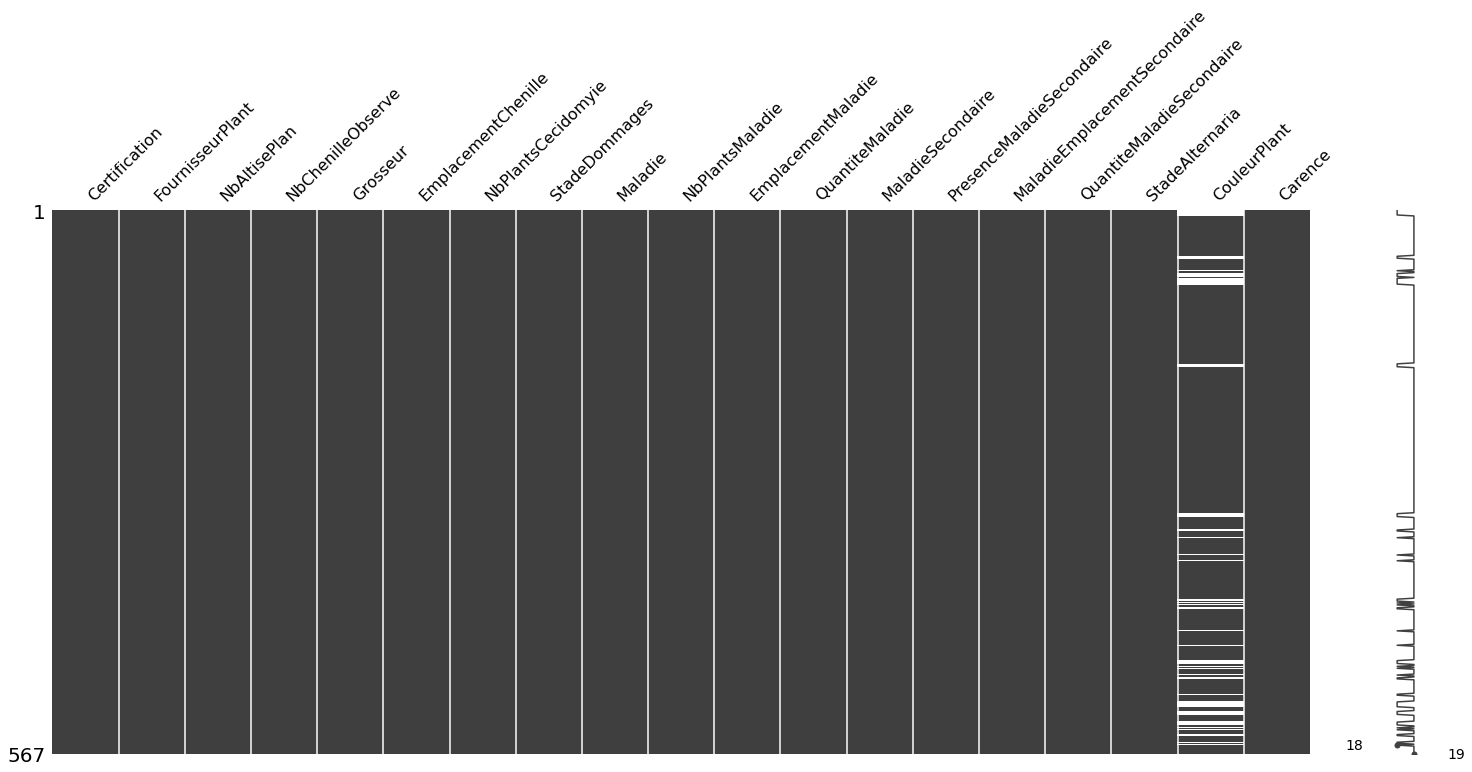

In [30]:
msno.matrix(df[cat])
plt.show()

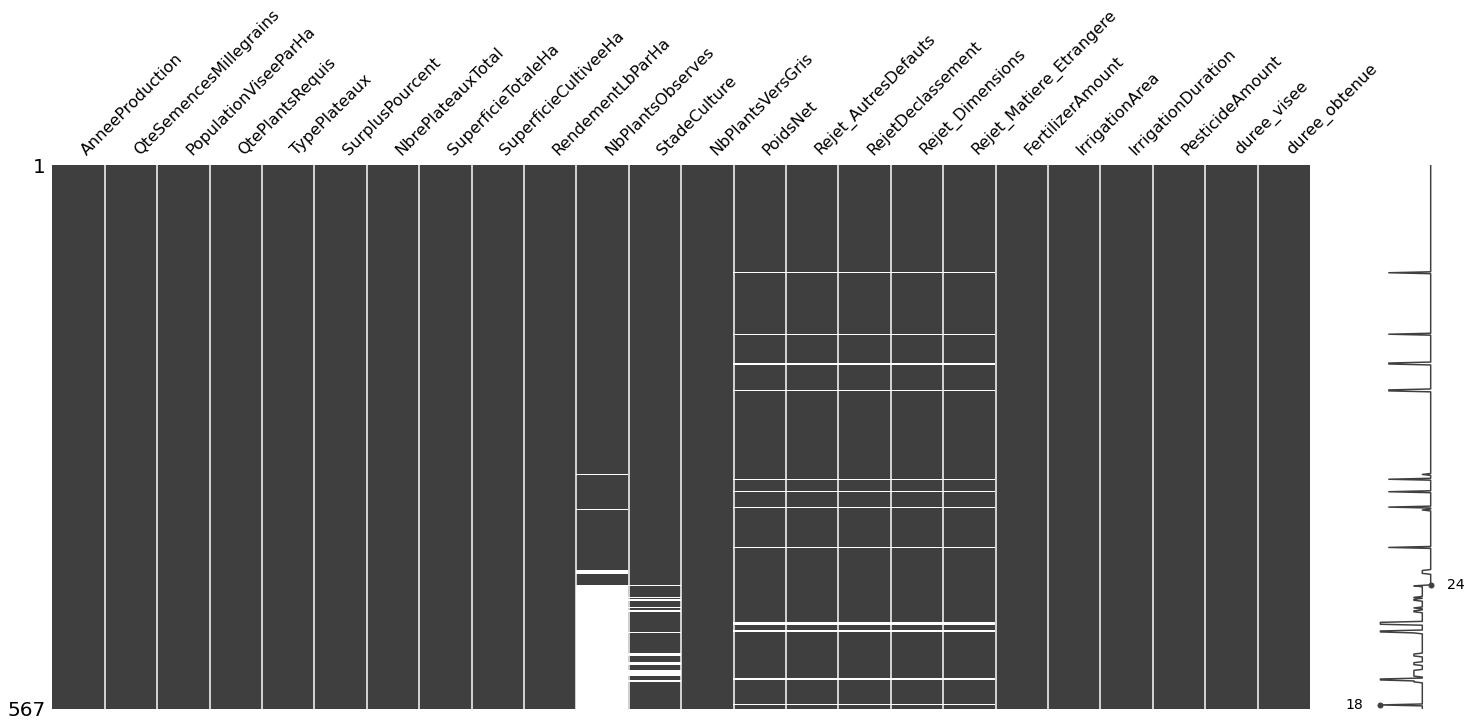

In [31]:
msno.matrix(df[num])
plt.show()

<AxesSubplot:>

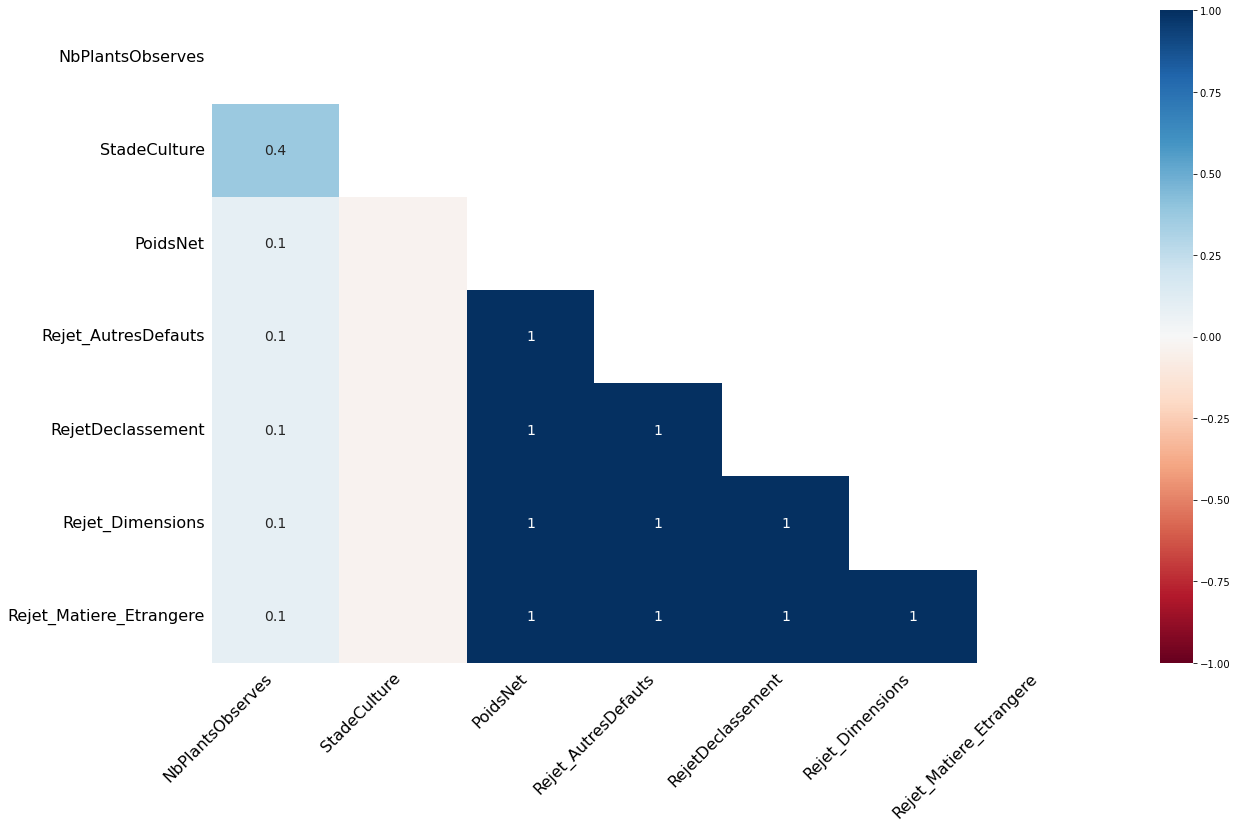

In [32]:
msno.heatmap(df[num])

#### Regroupement des variables qui ont des données manquantes à hauteur de 30%

In [33]:
colonnes = show_columns30(df[num])['Champs'].to_list()
colonnes

['NbPlantsObserves',
 'StadeCulture',
 'PoidsNet',
 'Rejet_AutresDefauts',
 'RejetDeclassement',
 'Rejet_Dimensions',
 'Rejet_Matiere_Etrangere']

#### Remplacement de ces données manquantes par la moyenne

In [34]:
for feature in colonnes:
    replace_with = df[feature].mean()
    df[feature].fillna(replace_with,inplace=True)

In [35]:
show_mv(df[cat])

,Champs,Val NaN %
17,CouleurPlant,13.2


#### Vérification des données manquantes

In [36]:
show_mv(df[num])

,Champs,Val NaN %


In [37]:
cols = show_mv(df[num])['Champs'].to_list()
features_to_drop = cat+cols
cols_to_predict = show_mv(df[cat])['Champs'].to_list()

#### Traitement des données manquantes catégorielles par la prédiction

In [38]:
sc = RobustScaler()

In [39]:
appended_data = []
for col_to_predict in cols_to_predict:
    features_to_drop.remove(col_to_predict)
    df_cleaned = df.drop(features_to_drop, axis=1).copy()
    df_with_val_to_predict = df_cleaned[df_cleaned[col_to_predict].notna()]    
    df_no_val_to_predict = df_cleaned[df_cleaned[col_to_predict].isna()]
    
    X = df_with_val_to_predict.drop(col_to_predict, axis=1).values
    Y = df_with_val_to_predict[col_to_predict].values

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    
    forest = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=False, 
                                max_features=0.6, min_samples_leaf=3, n_jobs=-1)

    forest.fit(X_train, Y_train)
    y_pred_train = forest.predict(X_train)
    y_pred = forest.predict(X_test)
    
    
    df_no_val_to_predict = df_no_val_to_predict.drop(col_to_predict, axis=1)
    prediction = forest.predict(df_no_val_to_predict)
    df_no_val_to_predict.insert(0, col_to_predict, prediction)
    
    frames = [df_with_val_to_predict, df_no_val_to_predict]
    df_final = pd.concat(frames)    

    frames2 = [df[features_to_drop],df_final]
    df = pd.concat(frames2, axis=1, join='inner')
    appended_data.append(df[col_to_predict])    
    df = df.drop(col_to_predict, axis=1).copy() 

df1 = pd.concat(appended_data, axis=1)
df = pd.concat([ df3,df1, df[features_to_drop], df_final.drop(col_to_predict, axis=1)], axis=1, join='inner')

In [40]:
df

,NomSemis,NomEspece,NomCultivar,NomChamp,CouleurPlant,Certification,FournisseurPlant,NbAltisePlan,NbChenilleObserve,Grosseur,...,Rejet_AutresDefauts,RejetDeclassement,Rejet_Dimensions,Rejet_Matiere_Etrangere,FertilizerAmount,IrrigationArea,IrrigationDuration,PesticideAmount,duree_visee,duree_obtenue
125,19-Bayonne-BR-78,Brocoli,Monaco NT,Bayonne/Bayonne/20B,Bordure feuille picot brun,CONV,Lefort,AUCUNE,PEU (1 à 2 /plant),"Petit (0,5-1 cm)",...,0.560000,0.000000,0.780000,0.270000,2743.00,0.0,0.0,30.3875,67,66
126,19-Bayonne-BR-79,Brocoli,Batory T,Bayonne/Bayonne/20B,Bordure feuille picot brun,CONV,Lefort,AUCUNE,PEU (1 à 2 /plant),"Petit (0,5-1 cm)",...,0.100000,0.000000,0.300000,0.300000,2523.57,0.0,0.0,27.6293,67,68
127,19-Bayonne-BR-80,Brocoli,Monaco NT,Bayonne/Bayonne/55,Bordure feuille picot brun,CONV,Lefort,AUCUNE,PEU (1 à 2 /plant),"Petit (0,5-1 cm)",...,0.660000,0.000000,0.980000,0.310000,2127.62,0.0,0.0,34.8918,66,73
128,19-Bayonne-BR-81,Brocoli,Batory T,Bayonne/Bayonne/55,Bordure feuille picot brun,CONV,Lefort,AUCUNE,PEU (1 à 2 /plant),"Petit (0,5-1 cm)",...,0.350000,0.000000,1.140000,0.240000,1993.86,0.0,0.0,46.2929,65,71
129,19-Bayonne-BR-82,Brocoli,Monaco NT,Bayonne/Bayonne/55,Bordure feuille picot brun,CONV,Lefort,AUCUNE,PEU (1 à 2 /plant),"Petit (0,5-1 cm)",...,0.870000,0.000000,0.320000,0.290000,2181.96,0.0,0.0,54.3140,65,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,22-Wolfe-BR-2,Brocoli,Monaco NT,Wolfe/,Vert,CONV,PMM,AUCUNE,ÉLEVÉE (> 5 plants),Toutes les grosseurs,...,0.546302,0.717268,1.101621,0.106539,5602.80,0.0,0.0,48.7857,65,-999
688,22-Wolfe-CF-1,Chou-fleur,Casper T,Wolfe/,Vert,CONV,PMM,AUCUNE,ÉLEVÉE (> 5 plants),Toutes les grosseurs,...,0.850000,0.640000,0.410000,0.000000,2734.20,0.0,0.0,17.6551,83,71
689,22-Wolfe-CF-2,Chou-fleur,Casper T,Wolfe/,Vert,CONV,PMM,AUCUNE,ÉLEVÉE (> 5 plants),Toutes les grosseurs,...,0.180000,0.660000,0.690000,0.010000,5316.50,0.0,0.0,11.6095,86,100
690,22-Wolfe-CF-3,Chou-fleur,Casper T,Wolfe/,Vert,CONV,PMM,AUCUNE,ÉLEVÉE (> 5 plants),Toutes les grosseurs,...,0.160000,0.590000,1.080000,0.010000,2907.80,0.0,0.0,4.8825,89,94


#### Sauvegarde de dataset nettoyé

In [41]:
df.to_csv('ml-datas/PMM_wodate_final_clean.csv')

In [42]:
df

,NomSemis,NomEspece,NomCultivar,NomChamp,CouleurPlant,Certification,FournisseurPlant,NbAltisePlan,NbChenilleObserve,Grosseur,...,Rejet_AutresDefauts,RejetDeclassement,Rejet_Dimensions,Rejet_Matiere_Etrangere,FertilizerAmount,IrrigationArea,IrrigationDuration,PesticideAmount,duree_visee,duree_obtenue
125,19-Bayonne-BR-78,Brocoli,Monaco NT,Bayonne/Bayonne/20B,Bordure feuille picot brun,CONV,Lefort,AUCUNE,PEU (1 à 2 /plant),"Petit (0,5-1 cm)",...,0.560000,0.000000,0.780000,0.270000,2743.00,0.0,0.0,30.3875,67,66
126,19-Bayonne-BR-79,Brocoli,Batory T,Bayonne/Bayonne/20B,Bordure feuille picot brun,CONV,Lefort,AUCUNE,PEU (1 à 2 /plant),"Petit (0,5-1 cm)",...,0.100000,0.000000,0.300000,0.300000,2523.57,0.0,0.0,27.6293,67,68
127,19-Bayonne-BR-80,Brocoli,Monaco NT,Bayonne/Bayonne/55,Bordure feuille picot brun,CONV,Lefort,AUCUNE,PEU (1 à 2 /plant),"Petit (0,5-1 cm)",...,0.660000,0.000000,0.980000,0.310000,2127.62,0.0,0.0,34.8918,66,73
128,19-Bayonne-BR-81,Brocoli,Batory T,Bayonne/Bayonne/55,Bordure feuille picot brun,CONV,Lefort,AUCUNE,PEU (1 à 2 /plant),"Petit (0,5-1 cm)",...,0.350000,0.000000,1.140000,0.240000,1993.86,0.0,0.0,46.2929,65,71
129,19-Bayonne-BR-82,Brocoli,Monaco NT,Bayonne/Bayonne/55,Bordure feuille picot brun,CONV,Lefort,AUCUNE,PEU (1 à 2 /plant),"Petit (0,5-1 cm)",...,0.870000,0.000000,0.320000,0.290000,2181.96,0.0,0.0,54.3140,65,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,22-Wolfe-BR-2,Brocoli,Monaco NT,Wolfe/,Vert,CONV,PMM,AUCUNE,ÉLEVÉE (> 5 plants),Toutes les grosseurs,...,0.546302,0.717268,1.101621,0.106539,5602.80,0.0,0.0,48.7857,65,-999
688,22-Wolfe-CF-1,Chou-fleur,Casper T,Wolfe/,Vert,CONV,PMM,AUCUNE,ÉLEVÉE (> 5 plants),Toutes les grosseurs,...,0.850000,0.640000,0.410000,0.000000,2734.20,0.0,0.0,17.6551,83,71
689,22-Wolfe-CF-2,Chou-fleur,Casper T,Wolfe/,Vert,CONV,PMM,AUCUNE,ÉLEVÉE (> 5 plants),Toutes les grosseurs,...,0.180000,0.660000,0.690000,0.010000,5316.50,0.0,0.0,11.6095,86,100
690,22-Wolfe-CF-3,Chou-fleur,Casper T,Wolfe/,Vert,CONV,PMM,AUCUNE,ÉLEVÉE (> 5 plants),Toutes les grosseurs,...,0.160000,0.590000,1.080000,0.010000,2907.80,0.0,0.0,4.8825,89,94


## Etude des corrélations

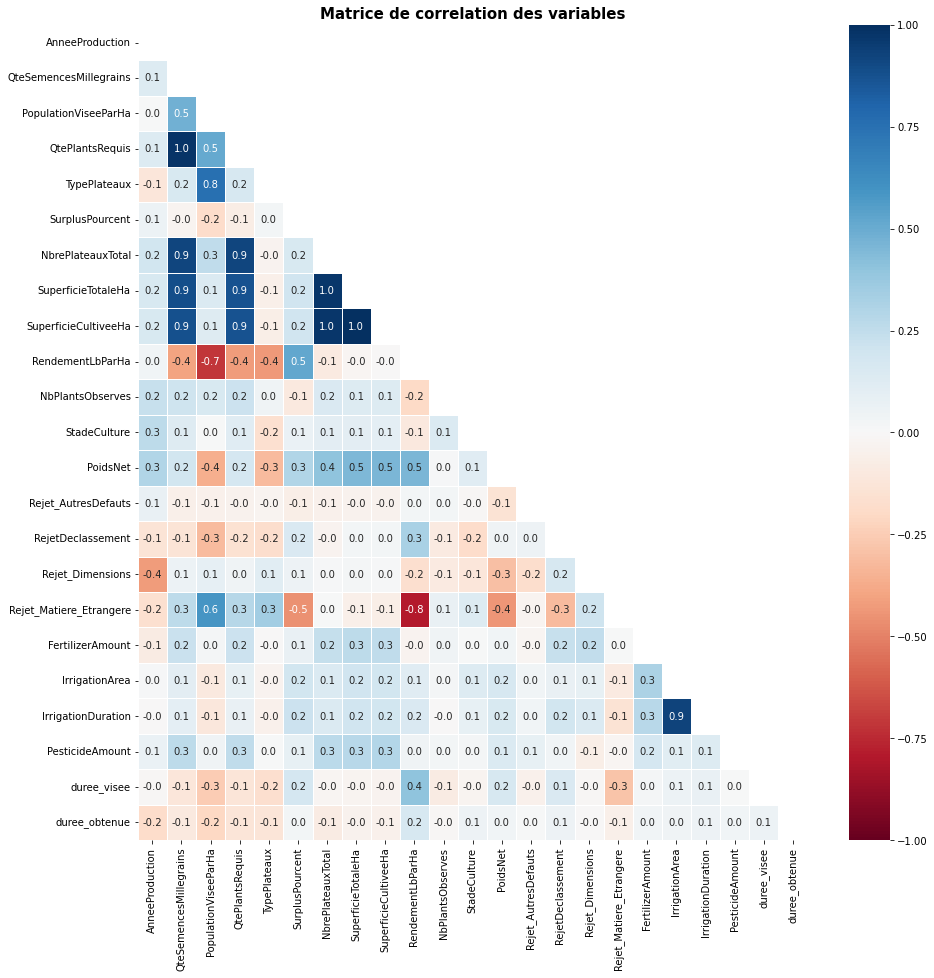

In [43]:
var_corr = ['QteSemencesMillegrains', 'PopulationViseeParHa', 'QtePlantsRequis', 'TypePlateaux', 'SurplusPourcent', 
            'NbrePlateauxTotal', 'SuperficieTotaleHa', 'SuperficieReelleHa', 'SuperficieCultiveeHa', 'RendementLbParHa',
            'FertilizerAmount', 'IrrigationArea', 'IrrigationDuration', 'PesticideAmount', 'NbreTotalBoite', 'PoidsBrut',
            'PoidsNet', 'PoidsPayable', 'PoidsPayableQualite1', 'PoidsRejete', 'CoteRendement',
            'NbPlantsObserves', 'DiametrePouce', 'PourPlantsMaladie', 'duree_visee', 'duree_obtenue']
# 'RejetBlessureMeca',

cols_to_drop = ['NbPlantsVersGris']
df2 = df.drop(cols_to_drop, axis=1)
matr_correlation(df2)

In [44]:
var_corr_bis = ['PopulationViseeParHa', 'TypePlateaux', 'NbrePlateauxTotal', 'SurplusPourcent', 'SuperficieCultiveeHa', 
                'QteSemencesMillegrains', 'SuperficieTotaleHa', 'RendementLbParHa', 'IrrigationArea', 'IrrigationDuration',
                'PoidsBrut', 'PoidsNet', 'PoidsPayable', 'PoidsPayableQualite1', 'PoidsRejete', 'duree_visee', 'duree_obtenue']

In [45]:
interact(bar_plot, variable = cat);

interactive(children=(Dropdown(description='variable', options=('Certification', 'FournisseurPlant', 'NbAltise…

In [46]:
interact(histo_plot, variable = var_corr_bis);

interactive(children=(Dropdown(description='variable', options=('PopulationViseeParHa', 'TypePlateaux', 'NbreP…

In [47]:
interact(box_plot, variable = var_corr_bis);

interactive(children=(Dropdown(description='variable', options=('PopulationViseeParHa', 'TypePlateaux', 'NbreP…

In [48]:
for feature in num:
    impute_outliers(df, feature)

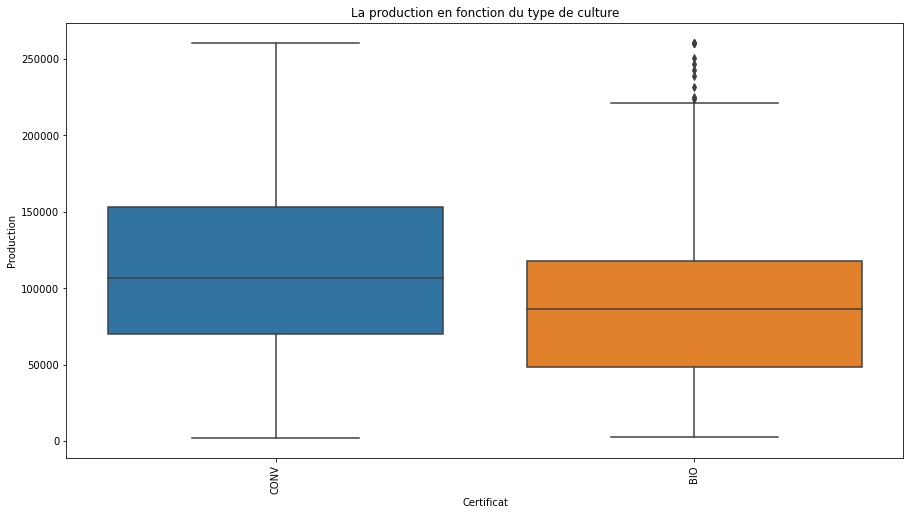

In [49]:
boxPlot(df, 'Certification', 'PoidsNet', 'Certificat', 'Production', 'La production en fonction du type de culture')

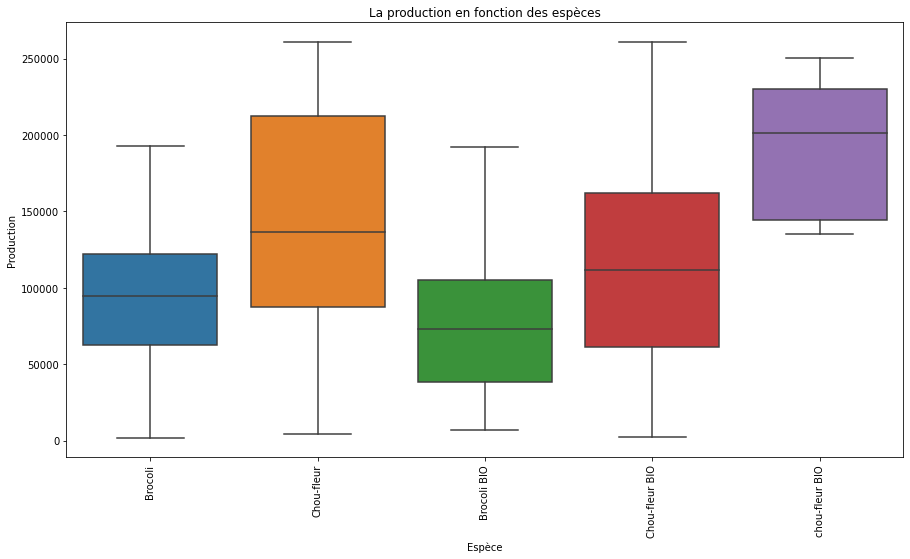

In [50]:
boxPlot(df, 'NomEspece', 'PoidsNet', 'Espèce', 'Production', 'La production en fonction des espèces')

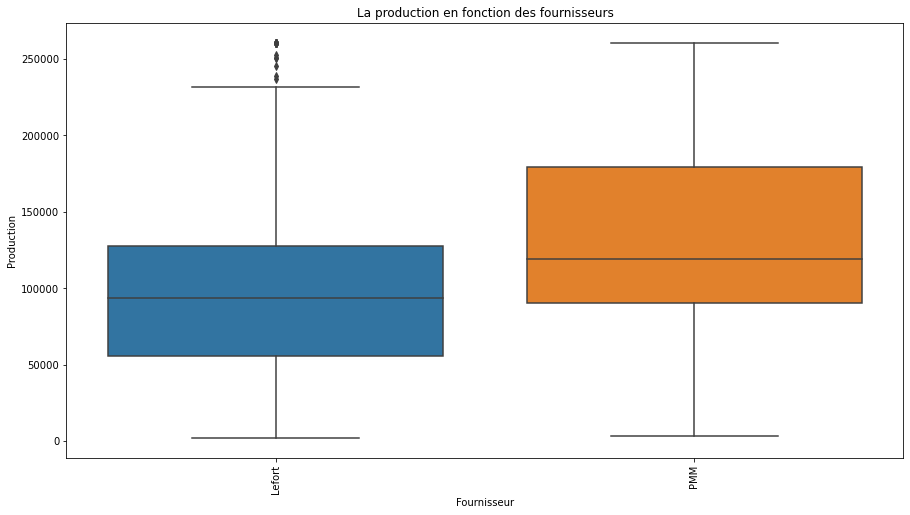

In [51]:
boxPlot(df, 'FournisseurPlant', 'PoidsNet', 'Fournisseur', 'Production', 'La production en fonction des fournisseurs')

In [52]:
df[num].describe()

,AnneeProduction,QteSemencesMillegrains,PopulationViseeParHa,QtePlantsRequis,TypePlateaux,SurplusPourcent,NbrePlateauxTotal,SuperficieTotaleHa,SuperficieCultiveeHa,RendementLbParHa,...,Rejet_AutresDefauts,RejetDeclassement,Rejet_Dimensions,Rejet_Matiere_Etrangere,FertilizerAmount,IrrigationArea,IrrigationDuration,PesticideAmount,duree_visee,duree_obtenue
count,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,...,567.000000,567.000000,567.000000,567.000000,567.000000,567.0,567.0,567.000000,567.000000,567.000000
mean,2020.402116,151.209857,36679.310278,133429.901278,257.389771,0.077884,554.868607,4.066510,3.610398,38195.916349,...,0.504645,0.396050,0.968782,0.106301,2514.706951,0.0,0.0,21.685414,73.557319,75.606261
std,1.123408,69.021581,8924.235389,58430.039783,42.005360,0.030602,217.242805,1.561878,1.365291,12541.323926,...,0.305916,0.585221,0.761969,0.106707,2861.175832,0.0,0.0,16.951605,12.714199,17.172833
min,2019.000000,0.000000,7175.940280,0.000000,145.500000,0.000000,65.500000,0.585000,0.624800,24250.820000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,36.500000,33.750000
25%,2019.000000,114.918511,28703.761120,96743.000000,231.000000,0.060000,455.500000,3.330000,2.974400,29762.370000,...,0.290000,0.000000,0.400000,0.000000,98.387800,0.0,0.0,7.401250,65.000000,66.000000
50%,2020.000000,167.285106,43055.641680,145998.810600,288.000000,0.060000,588.000000,4.170000,3.670000,29762.370000,...,0.440000,0.000000,0.720000,0.106539,1694.884200,0.0,0.0,18.348000,68.000000,71.000000
75%,2021.000000,196.697872,43055.641680,172268.492700,288.000000,0.100000,715.500000,5.160000,4.540800,55115.500000,...,0.670000,0.717268,1.360000,0.190000,4059.820350,0.0,0.0,33.133850,84.000000,87.500000
max,2022.000000,319.366915,64583.462520,285303.904000,373.500000,0.120000,1105.500000,7.905000,6.890400,55115.500000,...,1.240000,1.793169,2.800000,0.475000,10001.969175,0.0,0.0,71.732750,112.500000,119.750000


In [53]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [54]:
df[cat] = df[cat].apply(le.fit_transform)

In [55]:
df[cat]

,Certification,FournisseurPlant,NbAltisePlan,NbChenilleObserve,Grosseur,EmplacementChenille,NbPlantsCecidomyie,StadeDommages,Maladie,NbPlantsMaladie,EmplacementMaladie,QuantiteMaladie,MaladieSecondaire,PresenceMaladieSecondaire,MaladieEmplacementSecondaire,QuantiteMaladieSecondaire,StadeAlternaria,CouleurPlant,Carence
125,1,0,0,3,4,4,0,2,2,0,4,0,1,0,3,3,1,0,0
126,1,0,0,3,4,4,0,2,2,0,4,0,1,0,3,3,1,0,0
127,1,0,0,3,4,4,0,2,2,0,4,0,1,0,3,3,1,0,0
128,1,0,0,3,4,4,1,0,2,0,4,0,1,0,3,3,1,0,0
129,1,0,0,3,4,4,0,2,2,0,4,0,1,0,3,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,1,1,0,4,5,2,0,2,1,3,2,4,4,2,0,2,3,3,0
688,1,1,0,4,5,2,0,2,5,3,5,4,0,3,1,0,3,3,0
689,1,1,0,4,5,4,0,2,5,3,5,4,0,3,1,0,3,3,0
690,1,1,0,4,5,4,0,2,5,3,5,4,0,3,1,0,3,3,0


In [56]:
df_for_corr = pd.concat([df[cat], df[num]], axis=1)
df_for_corr

,Certification,FournisseurPlant,NbAltisePlan,NbChenilleObserve,Grosseur,EmplacementChenille,NbPlantsCecidomyie,StadeDommages,Maladie,NbPlantsMaladie,...,Rejet_AutresDefauts,RejetDeclassement,Rejet_Dimensions,Rejet_Matiere_Etrangere,FertilizerAmount,IrrigationArea,IrrigationDuration,PesticideAmount,duree_visee,duree_obtenue
125,1,0,0,3,4,4,0,2,2,0,...,0.560000,0.000000,0.780000,0.270000,2743.00,0.0,0.0,30.3875,67.0,66.00
126,1,0,0,3,4,4,0,2,2,0,...,0.100000,0.000000,0.300000,0.300000,2523.57,0.0,0.0,27.6293,67.0,68.00
127,1,0,0,3,4,4,0,2,2,0,...,0.660000,0.000000,0.980000,0.310000,2127.62,0.0,0.0,34.8918,66.0,73.00
128,1,0,0,3,4,4,1,0,2,0,...,0.350000,0.000000,1.140000,0.240000,1993.86,0.0,0.0,46.2929,65.0,71.00
129,1,0,0,3,4,4,0,2,2,0,...,0.870000,0.000000,0.320000,0.290000,2181.96,0.0,0.0,54.3140,65.0,70.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,1,1,0,4,5,2,0,2,1,3,...,0.546302,0.717268,1.101621,0.106539,5602.80,0.0,0.0,48.7857,65.0,33.75
688,1,1,0,4,5,2,0,2,5,3,...,0.850000,0.640000,0.410000,0.000000,2734.20,0.0,0.0,17.6551,83.0,71.00
689,1,1,0,4,5,4,0,2,5,3,...,0.180000,0.660000,0.690000,0.010000,5316.50,0.0,0.0,11.6095,86.0,100.00
690,1,1,0,4,5,4,0,2,5,3,...,0.160000,0.590000,1.080000,0.010000,2907.80,0.0,0.0,4.8825,89.0,94.00


## Etude des corrélation après la transformation

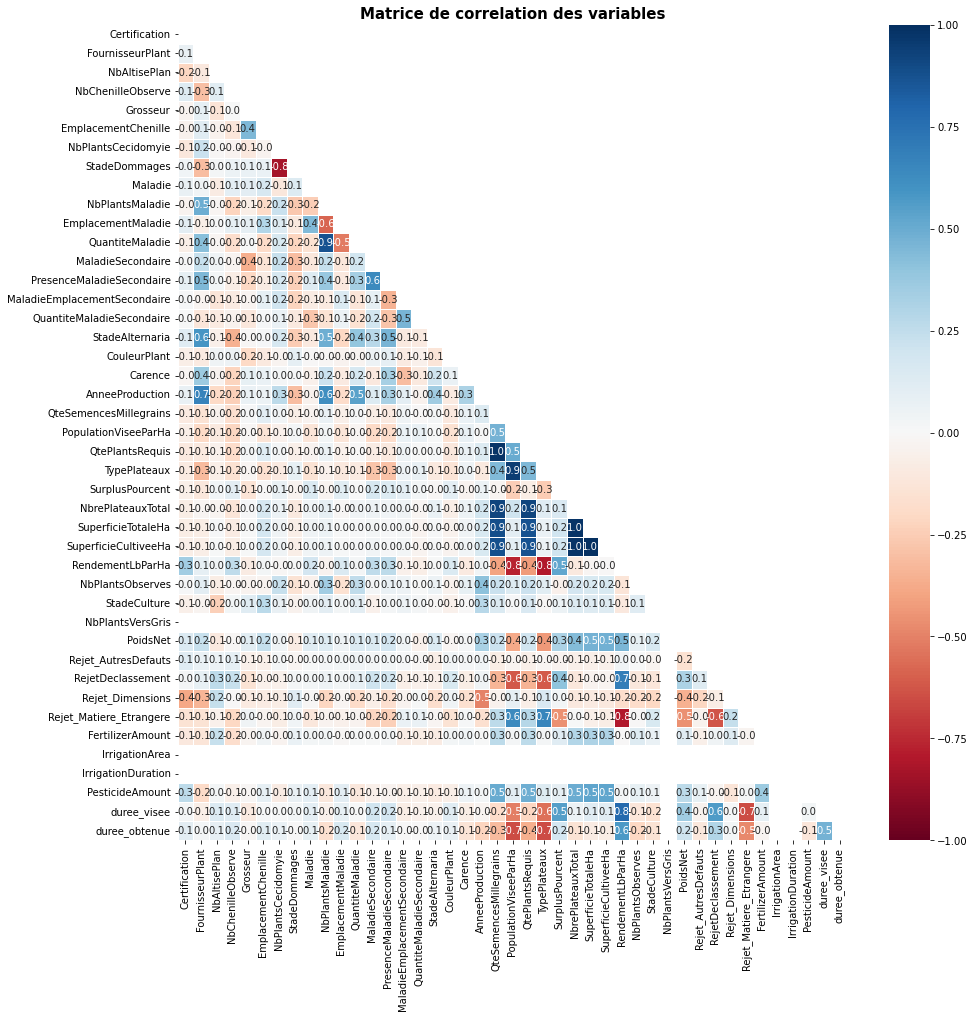

In [57]:
matr_correlation(df_for_corr)

## Développement du modèle

In [58]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
X = df_for_corr.drop('PoidsNet', axis=1)
Y = df_for_corr['PoidsNet']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=123)

rl = ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse', max_features=1.0,
                         min_samples_split=2, min_samples_leaf=1, n_estimators=100, n_jobs=-1, oob_score=False,
                         random_state=123)
cv = KFold(n_splits=10, shuffle=True, random_state=1)
n_scores = cross_val_score(rl, X, Y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')

rl.fit(X_train, Y_train)
y_pred_train = rl.predict(X_train)
y_pred = rl.predict(X_test)
# y_pred_proba = rl.pr(X_test)
r2_score_train = r2_score(Y_train, y_pred_train)
r2_score_test = r2_score(Y_test, y_pred)

print("R2 Score: TRAIN=%.4f TEST=%.4f" % (r2_score_train,r2_score_test))

R2 Score: TRAIN=1.0000 TEST=0.7019


In [59]:
train_features = X_train
train_labels = Y_train

## Sélection des features pour la prédiction

Text(0.5, 1.0, 'Importance des variables prédictives')

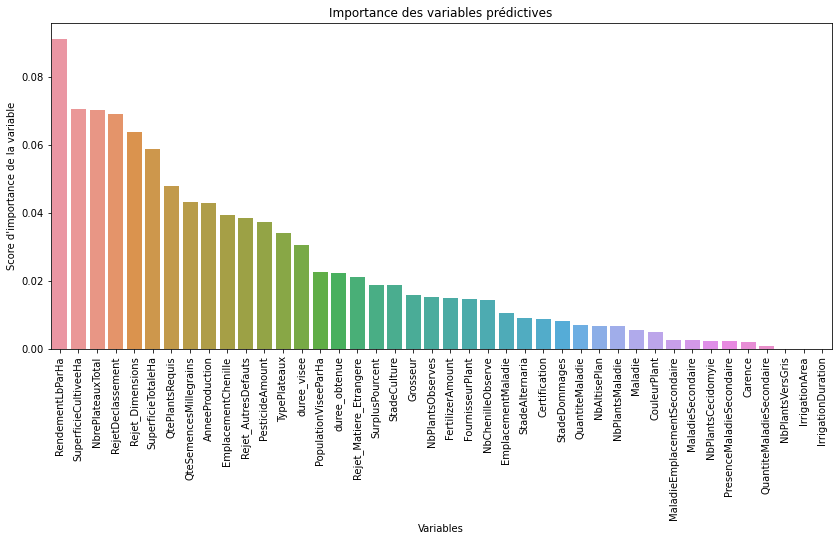

In [60]:
plt.figure(figsize=(14,6))
var_imp = pd.Series(rl.feature_importances_, index = train_features.columns).sort_values(ascending=False)
sns.barplot(x=var_imp.index, y=var_imp) 
plt.xticks(rotation=90)
plt.ylabel("Score d'importance de la variable")
plt.xlabel("Variables")
plt.title('Importance des variables prédictives')

In [61]:
var_imp
# rl.feature_importances_

RendementLbParHa                0.091251
SuperficieCultiveeHa            0.070477
NbrePlateauxTotal               0.070321
RejetDeclassement               0.069192
Rejet_Dimensions                0.063693
SuperficieTotaleHa              0.058828
QtePlantsRequis                 0.047986
QteSemencesMillegrains          0.043151
AnneeProduction                 0.042999
EmplacementChenille             0.039305
Rejet_AutresDefauts             0.038439
PesticideAmount                 0.037384
TypePlateaux                    0.034239
duree_visee                     0.030537
PopulationViseeParHa            0.022741
duree_obtenue                   0.022454
Rejet_Matiere_Etrangere         0.021371
SurplusPourcent                 0.019013
StadeCulture                    0.018746
Grosseur                        0.015815
NbPlantsObserves                0.015316
FertilizerAmount                0.014984
FournisseurPlant                0.014708
NbChenilleObserve               0.014435
EmplacementMalad

In [62]:
#FertilizerAmount
seuil = 0.009642
var_selected = var_imp[var_imp > seuil].index.to_list()
train_features = train_features[var_selected]
X_test = X_test[var_selected]

In [63]:
# from sklearn.model_selection import GridSearchCV

# # param_grid = {'C': [0.001, 0.01, 1, 10, 50, 100, 500]}

# param_grid = {
#    'bootstrap': [False], 
#    'ccp_alpha' : [0.0], 
#    'criterion': ['mse'], 
#    'max_features' : [1.0],
#    'min_samples_split' : [2], 
#    'min_samples_leaf' : [1], 
#    'n_estimators' : [100], 
#    'n_jobs' : [-1], 
#    'oob_score' : [False],
#    'random_state' : [123]
# }

# cv = KFold(n_splits=10, shuffle=True, random_state=1)
# grid_rl_reg = GridSearchCV(ExtraTreesRegressor(),param_grid=param_grid,cv=cv)

In [64]:
rl.fit(train_features, train_labels)
# print(rl_model.best_estimator_)

ExtraTreesRegressor(max_features=1.0, n_jobs=-1, random_state=123)

In [65]:
len(train_features.columns)

25

In [66]:
y_pred_train = rl.predict(train_features)
y_pred = rl.predict(X_test)
r2_score_test = r2_score(Y_test, y_pred)

#### Score obtenu sur le modèle avec Réduction des prédicteurs ou feature selection

In [67]:
r2_score_test

0.6978254086863807